In [ ]:
import os
import tempfile
import time
from datetime import datetime, timedelta
from os import path

import contextily as cx
import geopandas as gpd
import pandas as pd
import tqdm
from meteostations.clients import agrometeo

import tstore

# Your first TStore

In this tutorial, we will build a TStore of observations from the meteorological stations operated by [Agrometeo](https://www.agrometeo.ch/) [<sup>1</sup>](#agrometeo) in the Canton of Vaud, Switzerland during the last 5 years. We will use the [meteostations-geopy](https://github.com/martibosch/metastations-geopy) package to fetch the data. For this tutorial, you need to install the `feat-multivar-df` branch, e.g.:

```
pip install git+ssh://git@github.com/martibosch/meteostations-geopy.git@feat-multivar-df
```

Let us first have a look at the stations' locations:

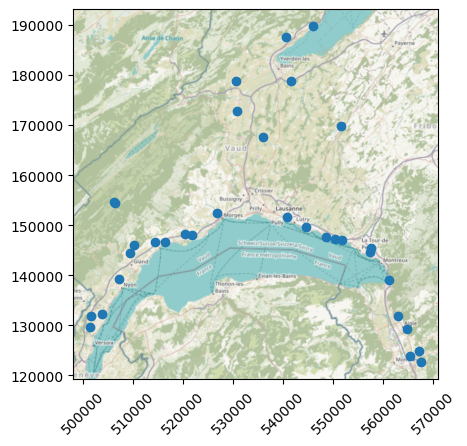

In [ ]:
region = "Canton de Vaud"

client = agrometeo.AgrometeoClient(region)

ax = client.stations_gdf.plot()
cx.add_basemap(ax=ax, crs=client.stations_gdf.crs, attribution="")
ax.tick_params(axis="x", labelrotation=45)
# ax.get_figure().savefig("")

Likewise many other APIs, Agrometeo limits the amount of data that can be fetched in a single request. Therefore, we will fetch the data in chunks of 1 month and concatenate it. Let's start by looking at 1-month chunk of data:

In [ ]:
variables = ["temperature", "water_vapour", "precipitation"]
start_date = "2021-01-01"
end_date = "2021-01-31"
client.get_ts_df(variables, start_date, end_date)

station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2021-01-01 00:00:00         2.2         99.0           0.2         2.5   
2021-01-01 00:10:00         2.3         99.0           0.2         2.6   
2021-01-01 00:20:00         2.4         99.0           0.1         2.8   
2021-01-01 00:30:00         2.4         99.0           0.2         2.8   
2021-01-01 00:40:00         2.5         99.0           0.2         2.8   
...                         ...          ...           ...         ...   
2021-01-31 23:10:00         5.7         99.0           0.0         6.6   
2021-01-31 23:20:00         5.9         99.0           0.4         6.6   
2021-01-31 23:30:00         6.1         99.0           0.2         6.5   
2021-01-31 23:40:00         6.1         98.0           0.3         6.5   
2021-01-31 23:50:00         6.1         99.0           0.3         6.5   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00         96.0           0.0         2.3         94.0   
2021-01-01 00:10:00         96.0           0.2         2.4         94.0   
2021-01-01 00:20:00         95.0           0.1         2.4         94.0   
2021-01-01 00:30:00         94.0           0.2         2.4         94.0   
2021-01-01 00:40:00         94.0           0.1         2.5         94.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00         93.0           0.5         5.7         96.0   
2021-01-31 23:20:00         94.0           0.4         6.0         95.0   
2021-01-31 23:30:00         94.0           0.4         6.1         95.0   
2021-01-31 23:40:00         95.0           0.3         6.2         94.0   
2021-01-31 23:50:00         96.0           0.9         6.2         94.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2021-01-01 00:00:00           0.2         3.2  ...           0.5         0.1   
2021-01-01 00:10:00           0.2         3.1  ...           0.4         0.0   
2021-01-01 00:20:00           0.2         3.3  ...           0.2        -0.0   
2021-01-01 00:30:00           0.2         3.1  ...           0.3         0.0   
2021-01-01 00:40:00           0.2         3.0  ...           0.3         0.1   
...                           ...         ...  ...           ...         ...   
2021-01-31 23:10:00           0.0         5.7  ...           0.1         5.6   
2021-01-31 23:20:00           0.6         5.8  ...           0.4         5.6   
2021-01-31 23:30:00           0.2         6.0  ...           0.0         5.7   
2021-01-31 23:40:00           0.4         5.8  ...           0.2         5.4   
2021-01-31 23:50:00           0.2         6.0  ...           0.2         5.3   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2021-01-01 00:00:00        100.0           0.0         0.3        100.0   
2021-01-01 00:10:00        100.0           0.0         0.3        100.0   
2021-01-01 00:20:00        100.0           0.0         0.2        100.0   
2021-01-01 00:30:00        100.0           0.0         0.2        100.0   
2021-01-01 00:40:00        100.0           0.0         0.2        100.0   
...                          ...           ...         ...          ...   
2021-01-31 23:10:00        100.0           0.1         6.6         88.0   
2021-01-31 23:20:00        100.0         

Let us now iteratively assemble 5 years of data:

In [ ]:
num_years = 5
# https://pandas.pydata.org/docs/user_guide/timeseries.html#period-aliases
freq = "1MS"

yesterday = datetime.now().replace(
    hour=0,
    minute=0,
    second=0,
    microsecond=0,
) - timedelta(days=1)
date_range = pd.date_range(
    yesterday - timedelta(days=365 * num_years),
    yesterday,
    freq=freq,
)

ts_df = pd.concat(
    [
        client.get_ts_df(variables, start_date, end_date - timedelta(days=1))
        for start_date, end_date in tqdm.tqdm(
            zip(date_range[:-1], date_range[1:]),
            total=len(date_range) - 1,
        )
    ],
)
ts_df

100%|█████████████████████████████████████████████████| 59/59 [00:56<00:00,  1.04it/s]


station                     1                                      3    \
variable            temperature water_vapour precipitation temperature   
time                                                                     
2019-06-01 00:00:00        17.0         57.0           0.0        13.4   
2019-06-01 00:10:00        16.5         60.0           0.0        13.3   
2019-06-01 00:20:00        16.3         59.0           0.0        12.9   
2019-06-01 00:30:00        16.3         60.0           0.0        13.3   
2019-06-01 00:40:00        15.7         64.0           0.0        12.8   
...                         ...          ...           ...         ...   
2024-04-30 23:10:00        13.6         71.0           0.0        13.1   
2024-04-30 23:20:00        13.6         69.0           0.0        12.8   
2024-04-30 23:30:00        13.1         73.0           0.0        12.3   
2024-04-30 23:40:00        12.3         78.0           0.0        12.2   
2024-04-30 23:50:00        12.1         82.0           0.0        12.1   

station                                                4                 \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-06-01 00:00:00         74.0           0.0        15.7         63.0   
2019-06-01 00:10:00         74.0           0.0        15.1         65.0   
2019-06-01 00:20:00         76.0           0.0        14.6         67.0   
2019-06-01 00:30:00         73.0           0.0        14.4         68.0   
2019-06-01 00:40:00         76.0           0.0        14.4         74.0   
...                          ...           ...         ...          ...   
2024-04-30 23:10:00         80.0           0.0        12.1         83.0   
2024-04-30 23:20:00         80.0           0.0        11.8         82.0   
2024-04-30 23:30:00         82.0           0.0        11.9         80.0   
2024-04-30 23:40:00         82.0           0.0        11.7         81.0   
2024-04-30 23:50:00         81.0           0.0        11.4         81.0   

station                                   10   ...           98          99   \
variable            precipitation temperature  ... precipitation temperature   
time                                           ...                             
2019-06-01 00:00:00           0.0        15.5  ...           0.0        14.5   
2019-06-01 00:10:00           0.0        15.2  ...           0.0        14.5   
2019-06-01 00:20:00           0.0        15.1  ...           0.0        14.3   
2019-06-01 00:30:00           0.0        14.9  ...           0.0        14.6   
2019-06-01 00:40:00           0.0        14.6  ...           0.0        14.8   
...                           ...         ...  ...           ...         ...   
2024-04-30 23:10:00           0.0        13.2  ...           0.0        13.0   
2024-04-30 23:20:00           0.0        13.3  ...           0.0        13.0   
2024-04-30 23:30:00           0.0        13.0  ...           0.0        12.3   
2024-04-30 23:40:00           0.0        12.8  ...           0.0        13.4   
2024-04-30 23:50:00           0.0        13.1  ...           0.0        12.9   

station                                                301               \
variable            water_vapour precipitation temperature water_vapour   
time                                                                      
2019-06-01 00:00:00         65.0           0.0        15.0         75.0   
2019-06-01 00:10:00         64.0           0.0        14.9         75.0   
2019-06-01 00:20:00         66.0           0.0        15.1         75.0   
2019-06-01 00:30:00         65.0           0.0        14.9         77.0   
2019-06-01 00:40:00         63.0           0.0        14.6         80.0   
...                          ...           ...         ...          ...   
2024-04-30 23:10:00         74.0           0.0        12.7         80.0   
2024-04-30 23:20:00         74.0         

###### TODO: implement `to_tstore` method for wide dataframes.

The data frame above corresponds to the "wide" format of the data. In order to build a TStore, we need to transform it into the "long" format. We can do this by stacking the columns of the data frame:

In [ ]:
long_ts_df = ts_df.stack(level=0, future_stack=True).swaplevel().sort_index()
long_ts_df

variable                     temperature  water_vapour  precipitation
station time                                                         
1       2019-06-01 00:00:00         17.0          57.0            0.0
        2019-06-01 00:10:00         16.5          60.0            0.0
        2019-06-01 00:20:00         16.3          59.0            0.0
        2019-06-01 00:30:00         16.3          60.0            0.0
        2019-06-01 00:40:00         15.7          64.0            0.0
...                                  ...           ...            ...
305     2024-04-30 23:10:00         14.4          84.0            0.0
        2024-04-30 23:20:00         14.9          74.0            0.0
        2024-04-30 23:30:00         14.9          74.0            0.0
        2024-04-30 23:40:00         15.3          69.0            0.0
        2024-04-30 23:50:00         15.3          67.0            0.0

[8534361 rows x 3 columns]

We can now dump this data frame into a tstore:

In [ ]:
def get_tstore_filepaths(base_dir):
    return [
        path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames
    ]


tstore_dir = "agrometeo-tstore"
tstore_structure = "id-var"
overwrite = True
id_var = "station"
time_var = "time"
# static_variables = ["variable"]
geometry = None  # NOT IMPLEMENTED YET

# Same partitioning for all TS
partitioning = "year"

tslong = tstore.TSLong(long_ts_df.reset_index())
start = time.time()
tslong.to_tstore(
    # TSTORE options
    tstore_dir,
    # DFLONG attributes
    id_var,
    time_var,
    variables,
    # static_variables=static_variables,
    # TSTORE options
    partitioning=partitioning,
    tstore_structure=tstore_structure,
    overwrite=overwrite,
)
print(f"Dumped tstore in: {time.time() - start:.2f} s")
tstore_filepaths = get_tstore_filepaths(tstore_dir)
for line in tstore_filepaths[:5] + ["..."] + tstore_filepaths[-5:]:
    if line.endswith("parquet"):
        print(line, f"({path.getsize(line)/1e6} MB)")
    else:
        print(line)

total_size = sum(path.getsize(tstore_filepath) for tstore_filepath in tstore_filepaths)
print(f"Total size: {total_size/1e6} MB (in {len(tstore_filepaths)} files)")
start = time.time()
ts_df = tstore.open_tslong(tstore_dir)
print(f"Read tstore in: {time.time() - start:.2f} s")

Dumped tstore in: 9.00 s
agrometeo-tstore/tstore_metadata.yaml
agrometeo-tstore/_attributes.parquet (0.001356 MB)
agrometeo-tstore/96/temperature/_common_metadata
agrometeo-tstore/96/temperature/_metadata
agrometeo-tstore/96/temperature/year=2020/part-0.parquet (0.539856 MB)
...
agrometeo-tstore/27/precipitation/year=2021/part-0.parquet (0.482791 MB)
agrometeo-tstore/27/precipitation/year=2019/part-0.parquet (0.280511 MB)
agrometeo-tstore/27/precipitation/year=2022/part-0.parquet (0.482202 MB)
agrometeo-tstore/27/precipitation/year=2023/part-0.parquet (0.482844 MB)
agrometeo-tstore/27/precipitation/year=2024/part-0.parquet (0.159689 MB)
Total size: 249.865824 MB (in 794 files)
Read tstore in: 21.60 s


We can see that this creates a hierarchical structure in which for each station id, a folder is created for variable. Each variable folder is composed of metadata as well as the actual data partitioned by months (as specified with the `partitioning` argument). Note that the file sizes are quite small which is likely inefficient [<sup>2</sup>](#parquet-file-size).

Note that we may be interested in reading a single variable, in which case reading times are dramatically reduced:

In [ ]:
start = time.time()
variable = "temperature"
T_ts_df = tstore.open_tslong(tstore_dir, ts_variables=variable)
print(f"Read tstore for {variable} in: {time.time() - start:.2f} s")
T_ts_df

Read tstore for temperature in: 1.40 s


,station,temperature,time
0,94,3.9,2024-01-01 00:00:00
1,94,3.8,2024-01-01 00:10:00
2,94,3.8,2024-01-01 00:20:00
3,94,3.9,2024-01-01 00:30:00
4,94,3.9,2024-01-01 00:40:00
...,...,...,...
8534356,94,26.2,2022-08-16 12:30:00
8534357,94,26.5,2022-08-16 12:40:00
8534358,94,26.9,2022-08-16 12:50:00
8534359,94,27.2,2022-08-16 13:00:00


We can also lazily read the whole TStore into a `TSDF` object:

In [ ]:
tsdf = tstore.open_tsdf(tstore_dir)
tsdf

,temperature,water_vapour,precipitation
station,,,
1,TS[shape=(Delayed('int-6b11458b-ed75-473d-9107...,TS[shape=(Delayed('int-68f9ff8d-1f22-4993-9a05...,TS[shape=(Delayed('int-e4774729-0486-4c6c-a792...
3,TS[shape=(Delayed('int-3ad5ce46-473e-425c-93ed...,TS[shape=(Delayed('int-3d49cc92-2f53-4d02-9f0a...,TS[shape=(Delayed('int-b74c2ec7-29d6-4363-ab3a...
4,TS[shape=(Delayed('int-674c7537-0c91-4817-9a58...,TS[shape=(Delayed('int-1ffffaf1-2cba-40b5-8b03...,TS[shape=(Delayed('int-7e07dbaa-e080-4f21-9572...
10,TS[shape=(Delayed('int-e019f82c-4143-41a0-880e...,TS[shape=(Delayed('int-f8580230-f9ef-4bb2-9995...,TS[shape=(Delayed('int-9491cd0d-7642-4e3f-97de...
13,TS[shape=(Delayed('int-4596d915-f250-4478-96b0...,TS[shape=(Delayed('int-02b8f028-dda7-4dee-b3fe...,TS[shape=(Delayed('int-251d7eff-8d90-49d2-94c7...
16,TS[shape=(Delayed('int-a695fecf-b37f-462b-b97f...,TS[shape=(Delayed('int-a65488f9-0598-4f60-997b...,TS[shape=(Delayed('int-e87e6b9c-794d-43cc-a8db...
22,TS[shape=(Delayed('int-f1fc0c54-b27a-49f4-81bc...,TS[shape=(Delayed('int-94406f1d-d566-4f72-9337...,TS[shape=(Delayed('int-63254366-d027-4414-915d...
27,TS[shape=(Delayed('int-30503a2c-a266-4e97-8bea...,TS[shape=(Delayed('int-6f70b174-480c-471d-88f1...,TS[shape=(Delayed('int-18f99135-fe65-4d86-90ac...
29,TS[shape=(Delayed('int-d963e424-389f-4bbb-9dd8...,TS[shape=(Delayed('int-d65a1f54-1050-4e3c-a366...,TS[shape=(Delayed('int-7e9d00c8-a496-401e-87c7...


and use the `TS.data.compute()` method after selecting the target data, so that only the required files are read:

In [ ]:
tsdf.loc["1", "precipitation"].data.compute()

variable,precipitation,time
0,0.0,2019-06-01 00:00:00
1,0.0,2019-06-01 00:10:00
2,0.0,2019-06-01 00:20:00
3,0.0,2019-06-01 00:30:00
4,0.0,2019-06-01 00:40:00
...,...,...
17414,0.0,2024-04-30 23:10:00
17415,0.0,2024-04-30 23:20:00
17416,0.0,2024-04-30 23:30:00
17417,0.0,2024-04-30 23:40:00


Let us now transform our `TSDF` object into a GeoDataFrame:

###### TODO: saving and reading a tstore transforms the station ids from integer to string. Should we always use strings for ids? If so, I will amend the code below so that `stations_gdf` has a string index.
###### TODO: fix the error based on the traceback

In [ ]:
gtsdf = gpd.GeoDataFrame(tsdf, geometry=client.stations_gdf["geometry"])
gtsdf

ValueError: maximum supported dimension for an ndarray is 32, found 33

###### TODO: example of reading with time filters

Let us now compare the I/O of tstore with a pandas CSV:

In [ ]:
with tempfile.TemporaryDirectory() as tmp_dir:
    csv_filepath = path.join(tmp_dir, "foo.csv")
    start = time.time()
    long_ts_df.to_csv(csv_filepath)
    print(f"Dumped csv in: {time.time() - start:.2f} s")
    print(f"Total size: {path.getsize(csv_filepath)/1e6} MB")
    start = time.time()
    ts_df = pd.read_csv(csv_filepath)
    print(f"Read csv in: {time.time() - start:.2f} s")

Dumped csv in: 141.17 s
Total size: 310.489551 MB
Read csv in: 7.72 s


As we can see, dumping the data to a tstore is about 18 times faster and takes about 80% of disk space. Although reading the CSV is about 3.5 times faster than reading the whole tstore, reading subsets of data (e.g., a single variable or a specific time period) can be significantly faster (about 6 times faster to read temperature only) using tstore and only loads the targeted data into memory (unlike the CSV which requires loading all the data).

## Footnotes

1. <span id="agrometeo"></span> Data from Agrometeo belongs to the Swiss Federal Administration, see [the terms and conditions](https://www.admin.ch/gov/en/start/terms-and-conditions.html) for more information.
2. <span id="parquet-file-size"></span> Individual parquet files should be at least of a few houndred MBs in size. See the ["Parquet file format – everything you need to know!" blog post](https://data-mozart.com/parquet-file-format-everything-you-need-to-know) for more details.  